# Analysis of Clusters
This notebook contains the scripts used to analyse the cluster typology of github projects obtain in the jupyter notebook "clustering.ipynb"

In [1]:
import networkx as nx
import pickle
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import MySQLdb
mpl.rcParams.update(mpl.rcParamsDefault)


In [2]:

colors=["#35a8e0", "#05c100", "#ffd300",'#d8b69f', '#d1000a']

# connect to ghtorrent data base 
# put your credentials and the database name below
db=MySQLdb.connect(
                 host="127.0.0.1",
                 user="root",
                 passwd="enterenter"
               )
cursor = db.cursor()
cursor.execute("use ghtorrent_restore")


def get_project_info(_id):
    cursor.execute("select owner_id, name from projects where id=%s"%(_id))
    project_data=cursor.fetchone()
    name=project_data[1]
    # get owner login name
    cursor.execute("select login from users where id=%s"%(project_data[0]))
    owner=cursor.fetchone()[0]
    return (name, owner)

def get_user(_id):
    cursor.execute("select * from users where id=%s"%(_id))
    return cursor.fetchone()

def get_graph_by_id(_id):
    return next(nw for nw in networkl if nw.graph['id']==_id)

In [3]:
#load final partion after clustering, clustering done in other file "agglomorative..."
final_partition= pickle.load(open("data/final_partition", "rb"))
networkl=pickle.load(open("data/networks8to20", "rb"))

# Programming language

To see wether the different group types differ in their use of programming language, we collect for each project the 

In [4]:
# get programming languages for projects in clusters from database

languages_dict={}
partition_languages= defaultdict(list)

count=0
for k, v in final_partition.items():
    cursor.execute("select * from project_languages where project_id = %s" %(k))
    langs = cursor.fetchall()
    langs_list =  list(set([x[1] for x in langs]))
    languages_dict[k] = langs_list
    partition_languages[v] += langs_list

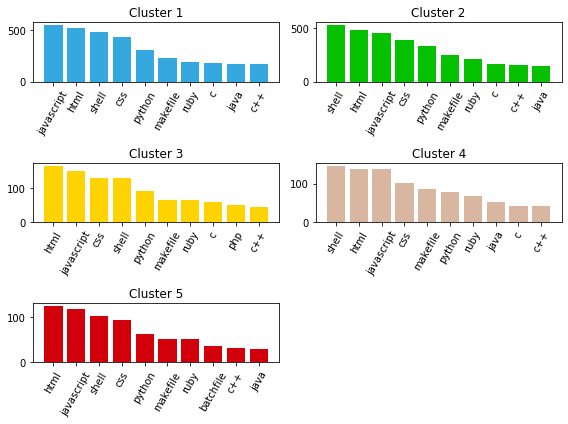

In [5]:
partition_languages_counts = {k: Counter(v) for k,v in partition_languages.items()}
partition_languages_most_common = {k: v.most_common(10) for k,v in partition_languages_counts.items()}
plt.figure(figsize=(8,6))
for k,v in partition_languages_most_common.items():
    plt.subplot(3,2,k+1)

    objects = [x[0] for x in v]
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, [x[1] for x in v], align='center', color=colors[k])
    plt.title("Cluster " + str(k+1))
    plt.xticks(y_pos, objects, rotation=60)
 #   ax.set_xticklabels( objects, )


    plt.tight_layout()

plt.show()


for all projects the 4 most used programming languages are "javascript, shell, html and css". Overall there does not seem to be much difference in terms of the use frequency of programming languages among clusters.

# Star distribution
The star count of a project is a measure of its popularity.
For all projects in each cluster we scrape the number of total stars that they had at the reference time frame from the data base. We also scrape the number of stars they gained only during that time period.

In [6]:
# get number of stars for projects in clusters from database

star_dict={}
partition_stars= defaultdict(list)
partition_totalstars= defaultdict(list)
partition_relativestars= defaultdict(list)
count=0
for k, v in final_partition.items():
    cursor.execute("select count(*) from watchers where repo_id = %s and created_at BETWEEN date('2016-09-01') AND date('2017-03-01')" %(k))
    stars=cursor.fetchone()
    cursor.execute("select count(*) from watchers where repo_id = %s and created_at <= date('2017-03-01')" %(k))
    totalstars= cursor.fetchone()
    star_dict[k]=[stars[0], totalstars[0]]
    partition_stars[v].append(stars[0])
    partition_totalstars[v].append(totalstars[0])
    if totalstars[0]!=0:
        partition_relativestars[v].append(stars[0]/totalstars[0])
    else:
        partition_relativestars[v].append(0)
    


In [7]:
clusters=[]
cl_stars=[]
cl_stars_std=[]

for k,v in partition_stars.items():
    clusters.append(k)
    cl_stars.append(np.mean(v))
    cl_stars_std.append(np.std(v))

In [8]:
#mean values
for k,v in partition_stars.items():
    print(k, np.mean(v))

0 272.24146110056927
1 77.81823745410037
2 145.33579335793357
3 97.5180265654649
4 45.12207792207792


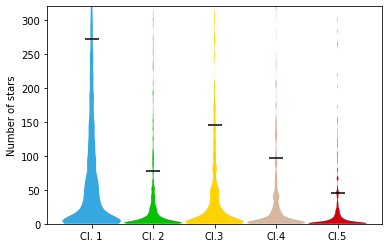

In [9]:
#plot star distributions and mean values per cluster
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,320])
plt.xticks([1,2,3,4,5], ("Cl. 1", "Cl. 2", "Cl.3", "Cl.4", "Cl.5"))
for i in range(5):
    y=partition_stars[i]
    #x=[i+1 for item in y]
    part=plt.violinplot(y, [i+1], points=5000, widths=0.95,
                      showmeans=False, showextrema=False, showmedians=False, bw_method=0.01)
    for pc in part['bodies']:
        pc.set_facecolor(colors[i])
        #pc.set_edgecolor('black')
        pc.set_alpha(1)
    plt.scatter(i+1,np.mean(y), marker="_",  c="#000000", s=200) # mark mean value 
plt.ylabel("Number of stars")
plt.show()



We see that the star distributions are all power law like by creating the log-log plot

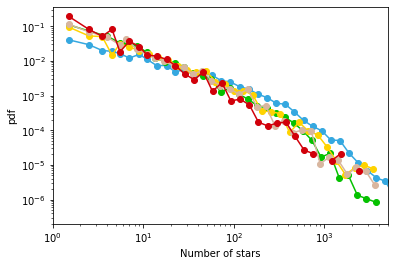

In [10]:
# plot pdf in loglog plot calculated with python package powerlaw

import powerlaw
for i in range(5):
    y=partition_stars[i]
    powerlaw.plot_pdf([x for x in y if x!=0],marker="o",  c=colors[i])
plt.xlim((1,5000))
plt.ylabel("pdf")
plt.xlabel("Number of stars")
plt.show()


# Flow hierarchy
To gain a single number for the level of hierarchy in a project, we calculate the flow hierarchy and plot the distributions for each cluster

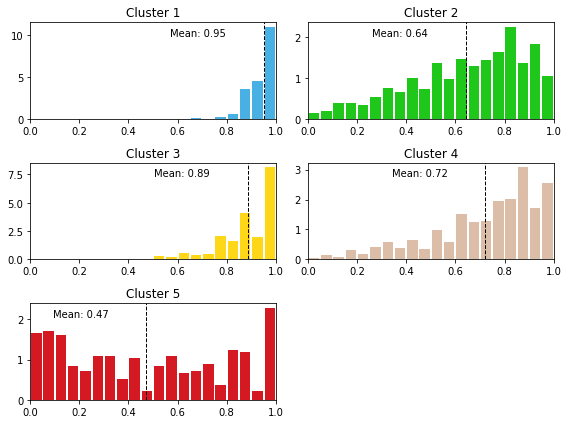

In [11]:
flow_hier=defaultdict(list)

for k,v in final_partition.items():
    flow_hier[v].append(nx.flow_hierarchy(get_graph_by_id(k)))



plt.figure(figsize=(8,6))
for k,v in flow_hier.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k+1), fontsize=12)
    sns.distplot(v, bins=[x/20 for x in range(21)], hist=True, color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean - 0.38, 
             max_ - max_/7, 
             'Mean: {:.2f}'.format(vmean))
    #plt.yscale('log', nonposy='clip')
    #plt.xscale('log') 
    plt.xlim(0, 1) 
plt.tight_layout()

plt.show()

# Productivity
We calculate the distributions for total number of pull requests per cluster in the reference time frame and average number of pull requests per group member in the reference time frame

In [12]:
def contrib(net):
    """ returns total number of pull requests
    """
    return nx.adjacency_matrix(net).sum()

def contrib_avg(net):
    """ returns average number of pull requests per group member
    """
    contribs=nx.adjacency_matrix(net).sum(axis=0)
    return contribs.mean()

In [13]:
contrib_vals=defaultdict(list)

for k,v in final_partition.items():
    contrib_vals[v].append(contrib(get_graph_by_id(k)))


In [14]:
contrib_vals_avg=defaultdict(list)

for k,v in final_partition.items():
    contrib_vals_avg[v].append(contrib_avg(get_graph_by_id(k)))


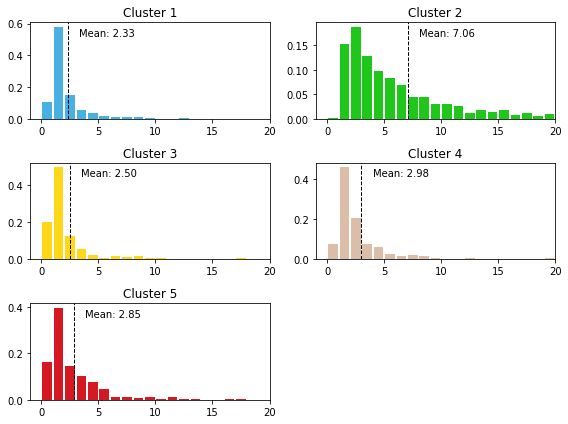

In [15]:
plt.figure(figsize=(8,6))
for k,v in contrib_vals_avg.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k+1), fontsize=12)
    sns.distplot(v, bins=[x for x in range(0,21,1)], hist=True, color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean + 1, 
             max_ - max_/7, 
             'Mean: {:.2f}'.format(vmean))
    plt.xlim(-1, 20) 
plt.tight_layout()

plt.show()

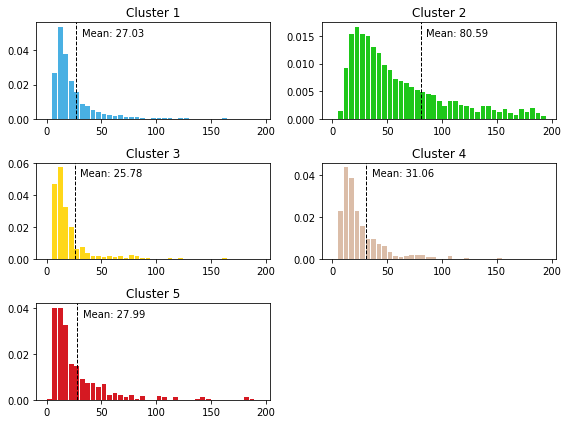

In [16]:
plt.figure(figsize=(8,6))
for k,v in contrib_vals.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k+1), fontsize=12)
    sns.distplot(v, bins=[x for x in range(0,200,5)], hist=True, color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean + 5, 
             max_ - max_/7, 
             'Mean: {:.2f}'.format(vmean))
    #plt.yscale('log', nonposy='clip')
    #plt.xscale('log') 
   # plt.xlim(-1, 20) 
plt.tight_layout()

plt.show()

# Resilience of projects

In [17]:
#Stability/ Vulnerability
def nodedegree(graph,node):
    try:
        return graph.degree(node, weight="weight") - graph.edges[node,node]["weight"]
    except:
        return graph.degree(node, weight="weight") - 0
    


def vulnerability(graph):
    size = graph.size(weight="weight")
    degrees = sorted([nodedegree(graph, node) for node in graph])
    return degrees[-1]/size


def vulnerability_out(graph):
    size = graph.size(weight="weight")
    degrees = sorted([x[1] for x in graph.out_degree(weight="weight")])
    return degrees[-1]/size

def most_important_node(graph):

    degrees = sorted([(nodedegree(graph, node), node) for node in graph], key=lambda variable: variable[0])
    return degrees[-1][1]
    

def vulnerability_fraction(graph, fraction):
    graph=nx.convert_node_labels_to_integers(ograph)
    full_size = graph.size(weight="weight")
    full_n = len(graph)
    startfraction = 1
    nn=0
    while startfraction > fraction:
        nn+=1
        remove_id=most_important_node(graph)
        #print(remove_id)
        graph.remove_node(remove_id)
        startfraction = graph.size(weight="weight")/full_size
    
    return (nn/full_n, nn)



### Fraction of pull requests submitted by the most active user
For each cluster we plot the distribution of pull requests submitted by the most active user.
This in turn is measure for the dependence on the most active user and thus indicates how resilient the projects would be against the loss of that user

In [18]:
cl_vulnerability_out=defaultdict(list)
for k,v in final_partition.items():
    cl_vulnerability_out[v].append(vulnerability_out(get_graph_by_id(k)))

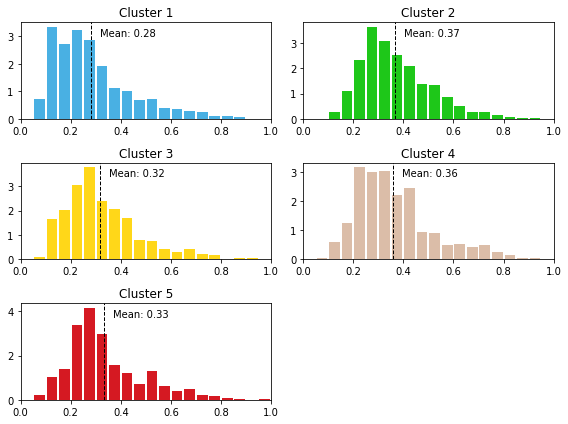

In [19]:
xshift=[-0.035, -0.035, -0.035, -0.035,-0.035]
i=0
plt.figure(figsize=(8,6))
for k,v in cl_vulnerability_out.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k +1), fontsize=12)
    sns.distplot(v, hist=True, bins=[x/20 for x in range(21)], color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean - xshift[i], 
             max_ - max_/7, 
             'Mean: {:.2f}'.format(vmean))
    plt.xlim(0, 1) 
    i+=1
plt.tight_layout()

plt.show()

### Fraction of pull requests with involvement of the most active user
For each cluster we plot the distribution of pull requests that were either submitted or merged by the most active user.
This is arguably a better measure for the dependence on the most active user since code review and merging pull requests is an important part of the software development work flow.

In [20]:
cl_vulnerability=defaultdict(list)
for k,v in final_partition.items():
    cl_vulnerability[v].append(vulnerability(get_graph_by_id(k)))

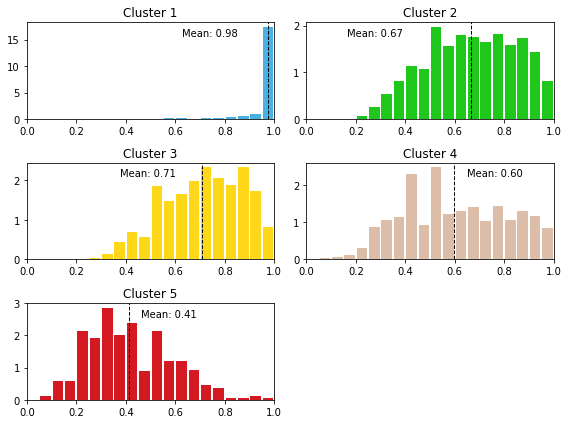

In [21]:
xshift=[0.35, 0.5,0.33, -0.05, -0.05]
i=0
plt.figure(figsize=(8,6))
for k,v in cl_vulnerability.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k + 1), fontsize=12)
    sns.distplot(v, hist=True, bins=[x/20 for x in range(21)], color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean - xshift[i], 
             max_ - max_/7, 
             'Mean: {:.2f}'.format(vmean))
    i+=1
    plt.xlim(0, 1) 
plt.tight_layout()

plt.show()